In [16]:
station_name = "Barbados"
test_year = 2020

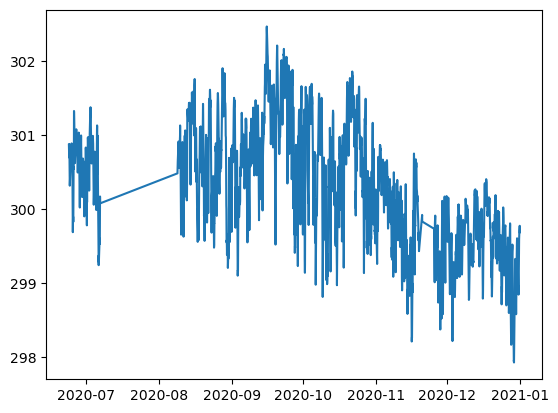

In [17]:
import xarray as xr

# era5_file in test folder
era5_file = f"/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_{station_name.lower()}.nc"
cleaned_station_file = f"/work/bm1159/XCES/xces-work/k203179/data/test/expected_{station_name.lower()}.nc"

ds = xr.open_dataset(era5_file)

time = ds.time.values
tas = ds.tas.values.mean(axis=(1,2))

import matplotlib.pyplot as plt
plt.plot(time, tas)
plt.show()


In [18]:
from climatereconstructionai import evaluate

evaluate(f"test_args_{station_name.lower()}.txt")

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


In [43]:


test_folder_path = "/work/bm1159/XCES/xces-work/k203179/data/test"
reconstructed_folder_path = "outputs/output_output.nc"
era5_file = f"{test_folder_path}/era5_for_{station_name.lower()}.nc"

from utils import DataSet, DatasetPlotter
import numpy as np

# plot era5 and output at timesteps [x, ...]
plot_timesteps = [1000]

era5_ds = DataSet(era5_file)
output_ds = DataSet(reconstructed_folder_path)

vmin = min(
    era5_ds.
)


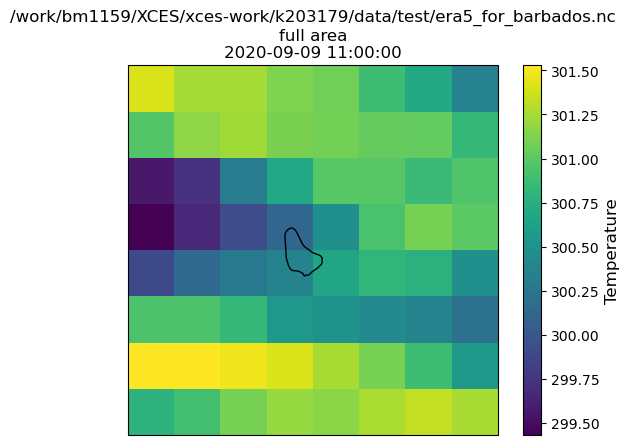

In [44]:

plotter = DatasetPlotter(era5_ds)
plotter.time_index_list = plot_timesteps
plotter.plot()

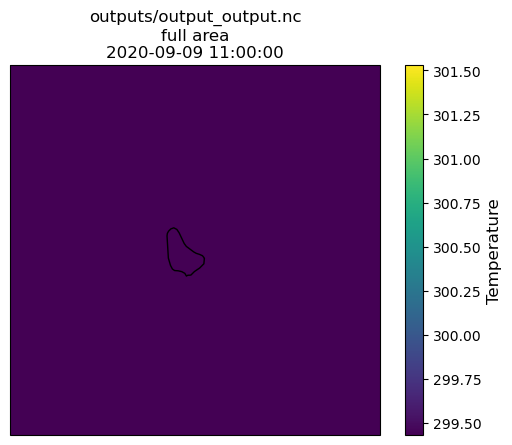

In [47]:
plotter = DatasetPlotter(output_ds)
plotter.time_index_list = plot_timesteps


# get min and max out of era5 at first timestep
era5_xarray_tmp = xr.open_dataset(f"/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_{station_name.lower()}.nc")
plotter.vmin = vmin
plotter.vmax = vmax

plotter.plot()

In [21]:
# get measurements values
measurements_data = xr.open_dataset(test_folder_path + f"/reality_{station_name.lower()}.nc")

In [22]:
# get coordinates from measurements nc file
import numpy as np

station_lon, station_lat = measurements_data.lon.values[0], measurements_data.lat.values[0]
print(f"station is at {station_lon}, {station_lat}")

# get nearest coordinates in era5
def get_left_right_nearest_elem_in_sorted_array(array, value):
    length = len(array)
    left = len(list(filter(lambda x: x <= value, array))) - 1
    right = length - len(list(filter(lambda x: x >= value, array)))
    nearest = min(left, right, key=lambda x: abs(array[x] - value))
    return left, right, nearest

test_array = [1, 2, 3, 4, 5, 6, 7, 8]
test_search = 5.51

print(f"searching for {test_search} in {test_array}")
left_idx, right_idx, nearest_idx =  get_left_right_nearest_elem_in_sorted_array(test_array, test_search)
print(f"idx left to {test_search} is {left_idx}, idx right to {test_search} is {right_idx}, nearest idx is {nearest_idx}")
print(f"mid crop: {test_array[left_idx:right_idx+1]}")


station is at -59.54316, 13.16443
searching for 5.51 in [1, 2, 3, 4, 5, 6, 7, 8]
idx left to 5.51 is 4, idx right to 5.51 is 5, nearest idx is 5
mid crop: [5, 6]


In [23]:
def era_vs_reconstructed_comparision_to_df():
    era5_data = xr.open_dataset(test_folder_path + f"/era5_for_{station_name.lower()}.nc")
    reconstructed_data = xr.open_dataset(reconstructed_folder_path)
    
    print(era5_data.lon.values)

    lon_left_idx, lon_right_idx, lon_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lon.values, station_lon % 360)
    lat_left_idx, lat_right_idx, lat_nearest_idx = get_left_right_nearest_elem_in_sorted_array(era5_data.lat.values, station_lat)

    era5_mid_values = era5_data.variables["tas"][:, lon_left_idx:lon_right_idx+1, lat_left_idx:lat_right_idx+1].mean(axis=(1,2))
    era5_nearest_values = era5_data.variables["tas"][:, lon_nearest_idx, lat_nearest_idx]
    
    reconstructed_data_values = reconstructed_data.variables["tas"].stack(grid=['lat', 'lon']).values  
    measurements_data_values = measurements_data.variables["tas"][:, 0, 0]

    # timeaxis 
    time = measurements_data.variables["time"][:]
    
    import pandas as pd

    # create dataframe with all values
    df = pd.DataFrame()

    df["time"] = time

    # index should be time
    df.set_index("time", inplace=True)

    df["era5_mid"] = era5_mid_values
    df["era5_nearest"] = era5_nearest_values
    df["reconstructed_median"] = [np.median(x) for x in reconstructed_data_values]
    df["reconstructed_mean"] = [np.mean(x) for x in reconstructed_data_values]
    df["reconstructed_min"] = [np.min(x) for x in reconstructed_data_values]
    df["reconstructed_max"] = [np.max(x) for x in reconstructed_data_values]
    
    df["measurements"] = measurements_data_values

    return df


# Generate Dataframe
- makes resampling easier

In [24]:
hourly_df = era_vs_reconstructed_comparision_to_df()
hourly_df

[299.53125 299.8125  300.09375 300.375   300.65625 300.9375  301.21875
 301.5    ]


,era5_mid,era5_nearest,reconstructed_median,reconstructed_mean,reconstructed_min,reconstructed_max,measurements
time,,,,,,,
2020-06-23 18:00:00,300.619324,300.467468,300.944153,300.940643,300.900177,300.980835,301.148276
2020-06-23 19:00:00,300.612030,300.464081,300.873718,300.868896,300.823059,300.918121,299.438333
2020-06-23 20:00:00,300.582092,300.439514,300.387634,300.392761,300.345764,300.431641,299.860000
2020-06-23 21:00:00,300.404968,300.436218,299.047241,299.046631,298.985657,299.125427,299.188333
2020-06-23 22:00:00,300.841553,300.861084,298.261780,298.256134,298.169678,298.326141,298.666667
...,...,...,...,...,...,...,...
2020-12-31 19:00:00,299.635986,299.627686,296.022827,296.016388,295.935242,296.052002,297.115517
2020-12-31 20:00:00,299.632629,299.626770,296.477905,296.467224,296.377563,296.520050,289.076471
2020-12-31 21:00:00,299.651733,299.692261,296.282532,296.277618,296.217590,296.306061,291.968750


# Implement plotting method of dataframe

In [25]:
def plot_n_steps_of_df(df, as_delta, n=None, title=None, boxplot=False):
    
    from matplotlib import pyplot as plt

    time = df.index.values
    if n is None:
        n = len(df)
    
    # random slice of n consecutive datapoints
    import random
    slice_start = random.randint(0, len(time) - n)
    time_slice = slice(slice_start, slice_start + n)

    time = time[time_slice]

   # era5_mid_values = df["era5_mid"].values -273.15
    era5_nearest_values = df["era5_nearest"].values - 273.15
    reconstructed_mean_values = df["reconstructed_mean"].values - 273.15
    reconstructed_median_values = df["reconstructed_median"].values - 273.15
    reconstructed_min_values = df["reconstructed_min"].values - 273.15
    reconstructed_max_values = df["reconstructed_max"].values - 273.15
    
    measurements_values = df["measurements"].values - 273.15
    
    average_error = abs(reconstructed_median_values[time_slice] - measurements_values[time_slice]).mean()
    
    rmse_reconstructed = np.sqrt(np.sum((reconstructed_median_values[time_slice] - measurements_values[time_slice])**2) / len(time))
   # rmse_era5_mid = np.sqrt(np.sum((era5_mid_values[time_slice] - measurements_values[time_slice])**2) / len(time))
    rmse_era5_nearest = np.sqrt(np.sum((era5_nearest_values[time_slice] - measurements_values[time_slice])**2) / len(time))
    
    correlation_reconstructed = np.corrcoef(reconstructed_median_values[time_slice], measurements_values[time_slice])[0,1]
   # correlation_era5_mid = np.corrcoef(era5_mid_values[time_slice], measurements_values[time_slice])[0,1]
    correlation_era5_nearest = np.corrcoef(era5_nearest_values[time_slice], measurements_values[time_slice])[0,1]
    
    if as_delta:
     #   era5_mid_values = era5_mid_values - measurements_values
        era5_nearest_values = era5_nearest_values - measurements_values
        reconstructed_mean_values = reconstructed_mean_values - measurements_values
        reconstructed_median_values = reconstructed_median_values - measurements_values
        reconstructed_min_values = reconstructed_min_values - measurements_values
        reconstructed_max_values = reconstructed_max_values - measurements_values
        measurements_values = measurements_values - measurements_values  
        
        # y-axis title, temperature difference  
        plt.ylabel("Delta calculated by subtracting measurement data [C°]")

    else:
        plt.ylabel("Temperature at surface [C°]")
    

    plt.plot(time, era5_nearest_values[time_slice], label="ERA5 nearest point", color="red")
    # plt.plot(time, era5_mid_values[time_slice], label="ERA5 nearest 4 points")
    
    if boxplot:
        for i in range(len(time)):
            plt.vlines(time[i], reconstructed_min_values[time_slice][i], reconstructed_max_values[time_slice][i], color="black", linewidth=1)
        plt.scatter(time, reconstructed_median_values[time_slice], label="Reconstructed", color="blue", s=8)
    else:
        plt.plot(time, reconstructed_median_values[time_slice], label="Reconstructed", color="blue")
    
    plt.plot(time, measurements_values[time_slice], label="Measurements", color="black")

    # x-axis labels 90 degrees
    plt.xticks(rotation=45)
    
    # title
    if title is not None:
        plt.title(title)
    
    # subtitle below title with average error rounded to 2 digits
    plt.suptitle(f"Average error of reconstruction median: {average_error:.2f} C°", fontsize=10, fontweight='bold')
    
    # font size of legend
    plt.rcParams.update({'font.size': 10})
    
    # font size of axis labels
    plt.rcParams.update({'axes.labelsize': 12})

    plt.legend()
    # position legend below chart to the right
    plt.legend(bbox_to_anchor=(1, -0.25), loc='upper right', borderaxespad=0.)
    
        
    # text below diagram with RMSE and Correlation in fontsize 10
    plt.text(0.1,-0.15, f"RMSE reconstructed: {rmse_reconstructed:.2f} C°\n" + 
             f"RMSE ERA5 nearest point: {rmse_era5_nearest:.2f} C°",
            
             fontsize=10, transform=plt.gcf().transFigure)
    
    plt.text(0.3, -0.15, f"Correlation reconstructed: {correlation_reconstructed:.2f}\n" + 
             f"Correlation ERA5 nearest point: {correlation_era5_nearest:.2f}",
             
             fontsize = 10, transform=plt.gcf().transFigure)
    
    # figure size A4 landscape
    plt.gcf().set_size_inches(16, 8)
    
    plt.show()

Plot Hourly (deltas), so errors against real measurements

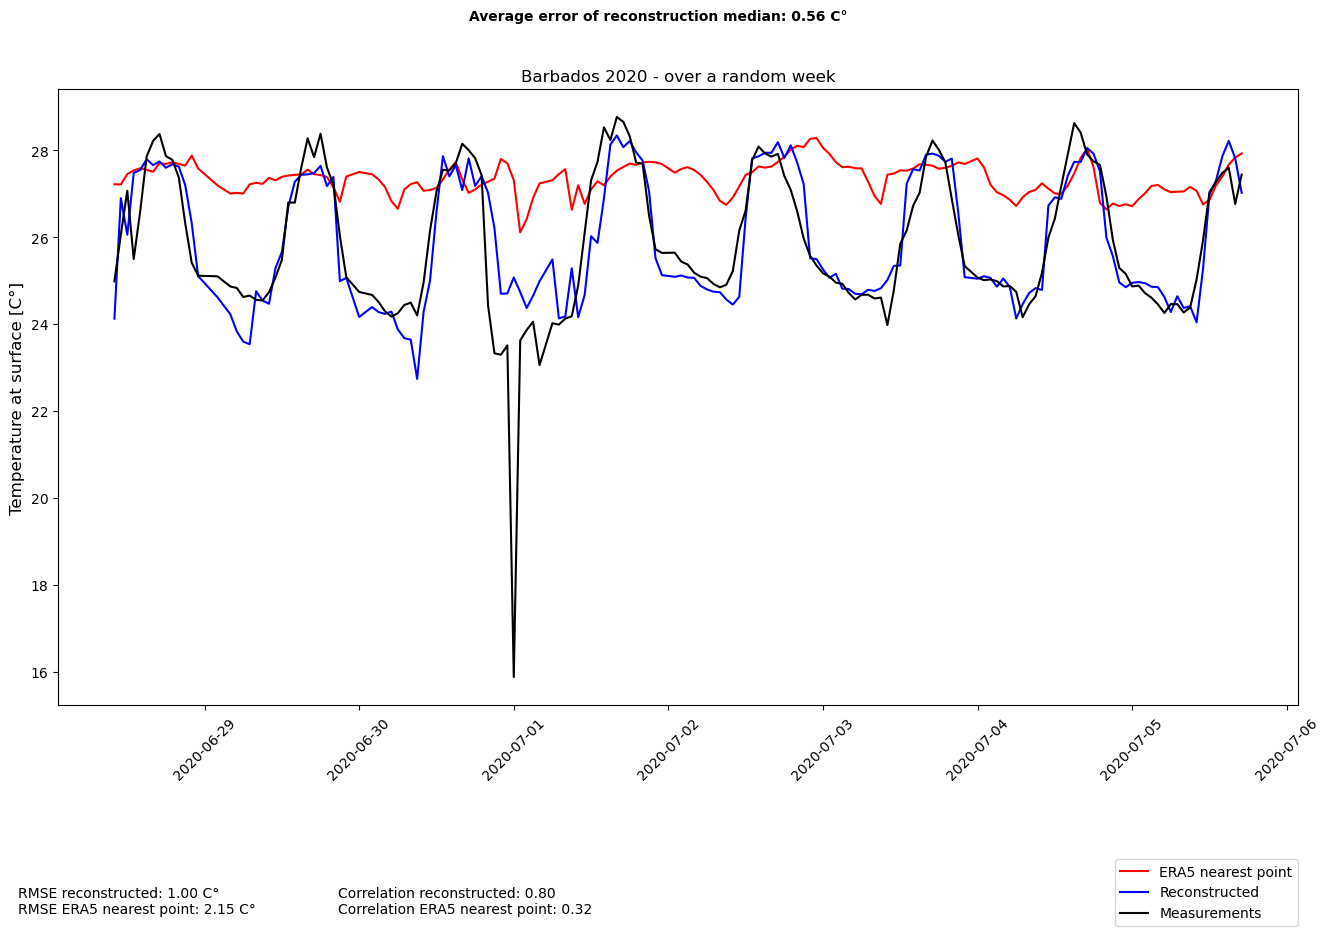

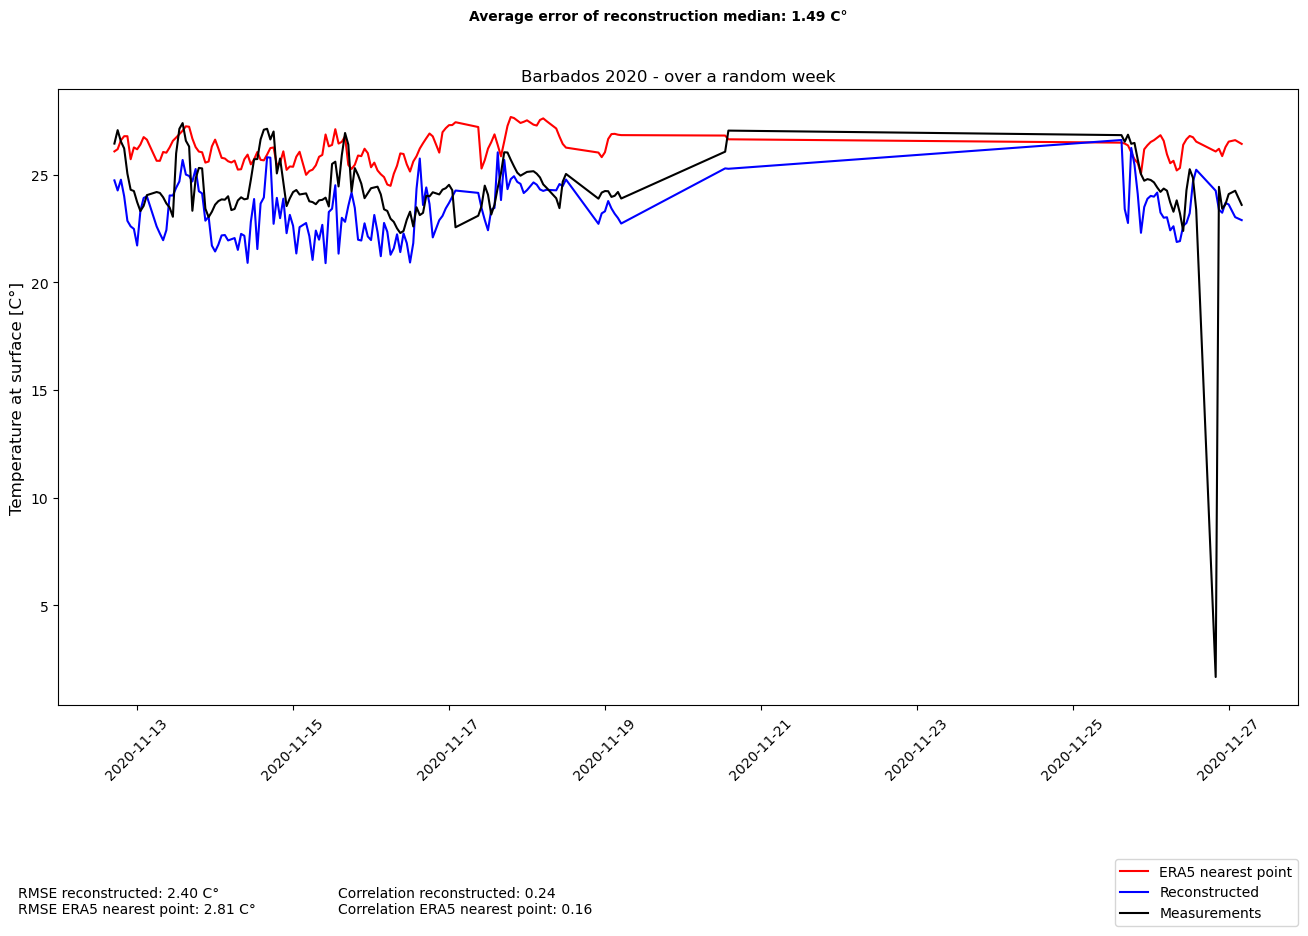

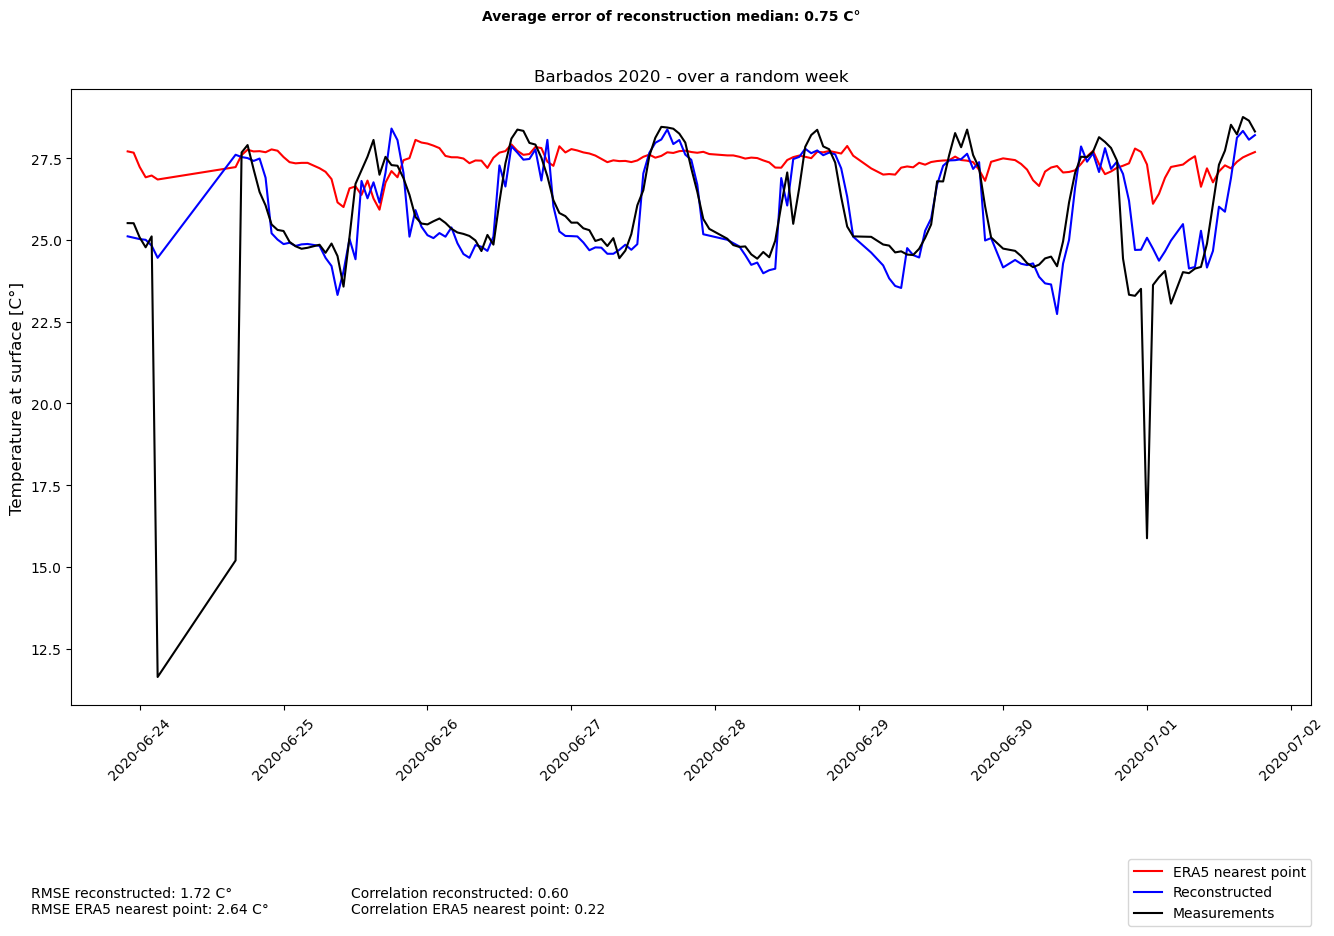

In [26]:
n = 168
if n == 168:
    title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - over a random week"
else:
    title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - {n} random consecutive hourly steps"
plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title)
plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title)
plot_n_steps_of_df(hourly_df, as_delta=False, n=n, title=title)

## Resample Data from hourly to daily or monthly




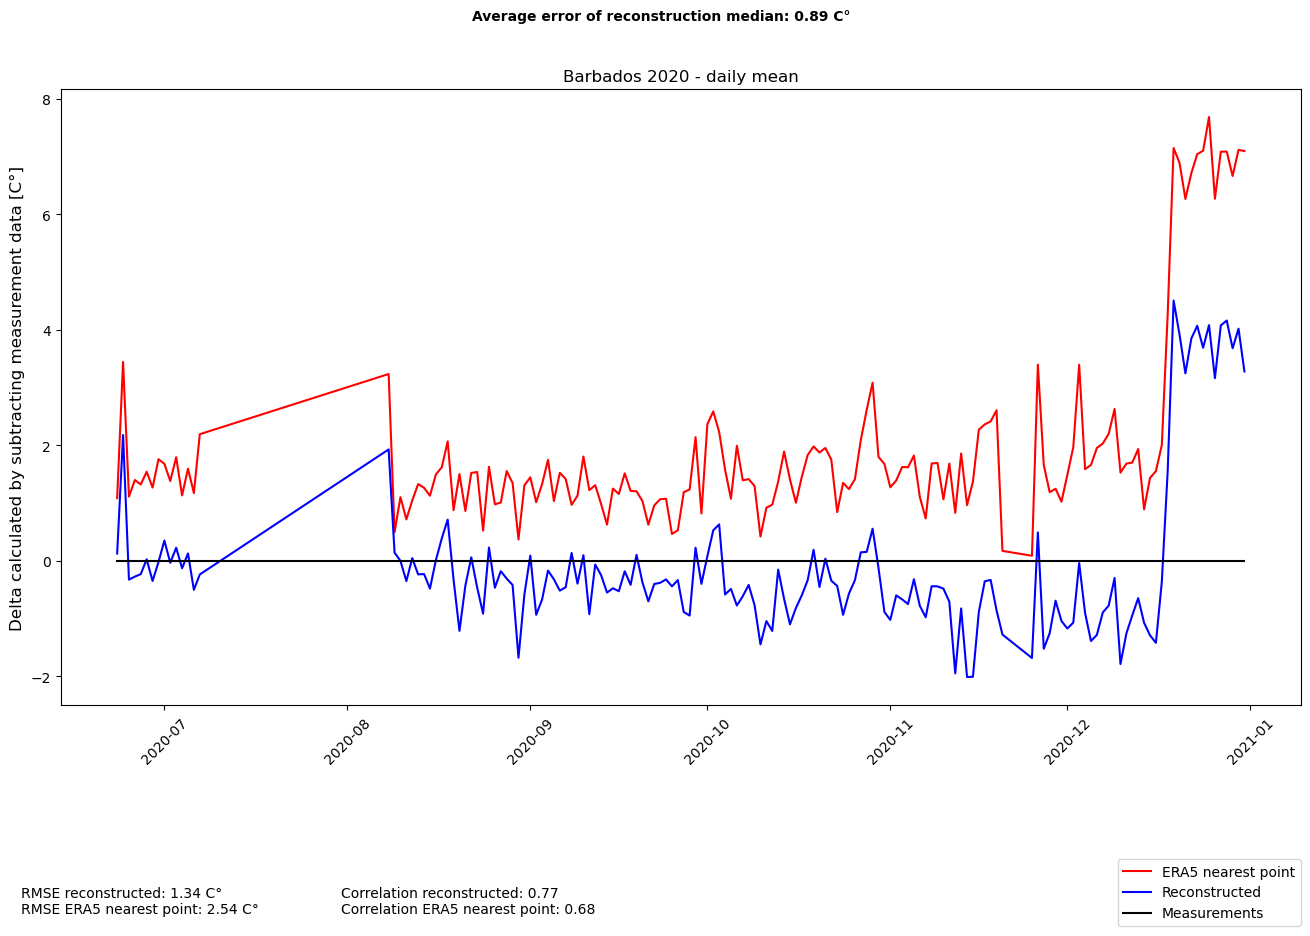

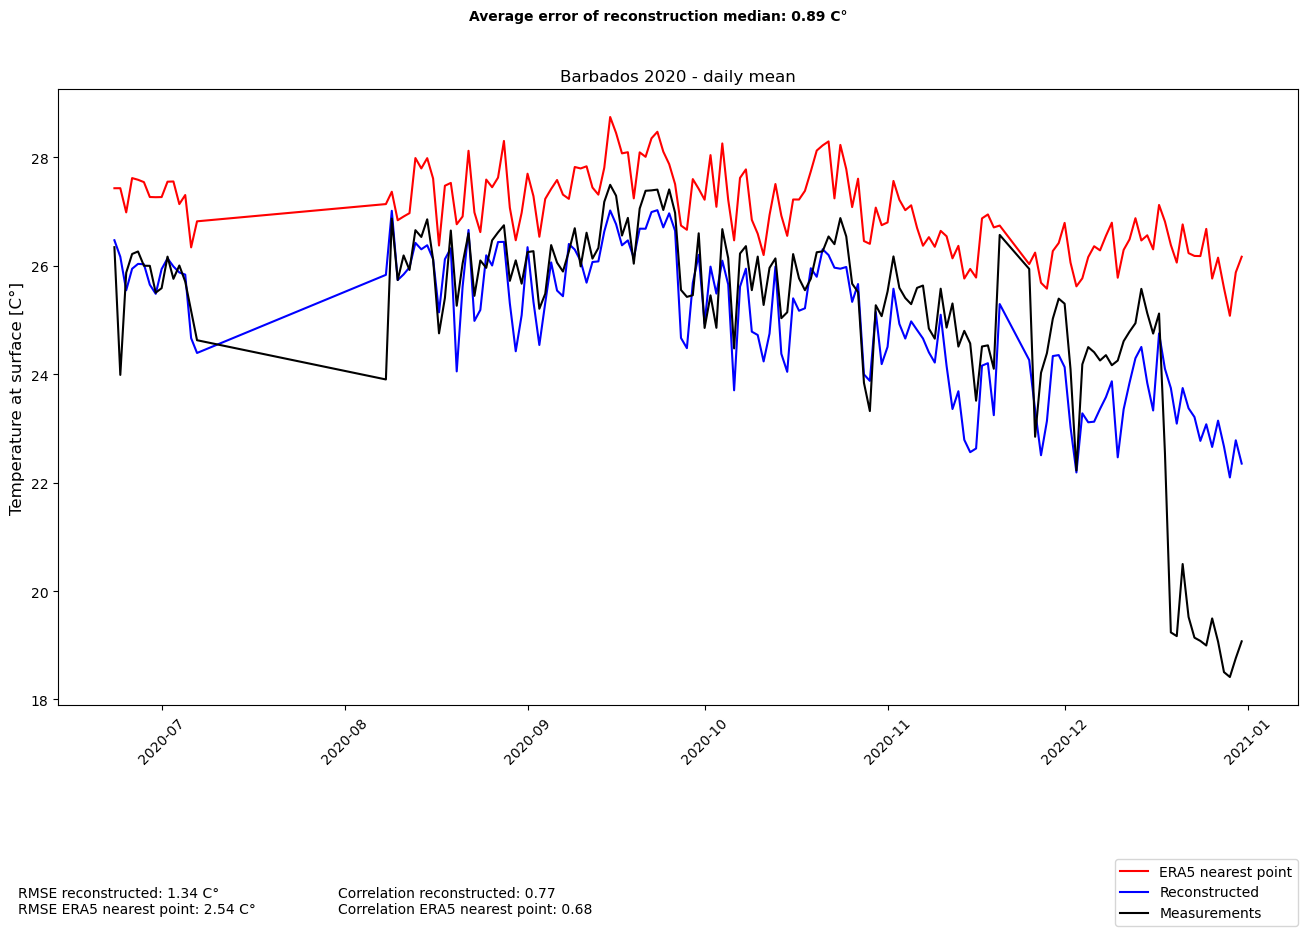

In [31]:
# drop reconstructed column
daily_df = hourly_df.resample("D").mean()
# drop nans
daily_df = daily_df.dropna()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - daily mean"
plot_n_steps_of_df(daily_df, as_delta=True, title=title)
plot_n_steps_of_df(daily_df, as_delta=False, title=title)

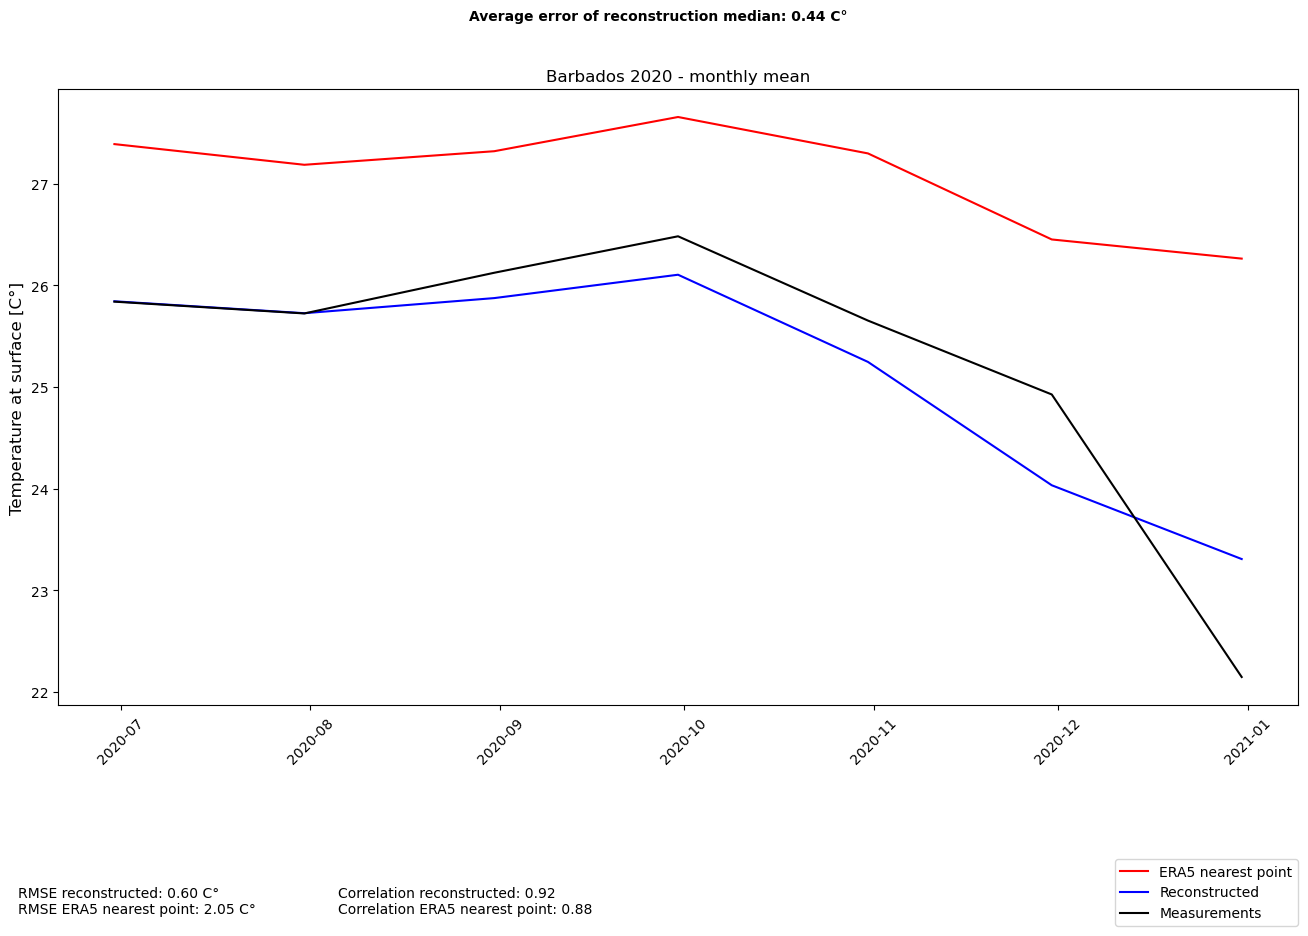

In [28]:
# resample rows to monthly mean
df = hourly_df.resample("M").mean()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - monthly mean"
plot_n_steps_of_df(df, as_delta = False, title=title)

# Average Course of the day

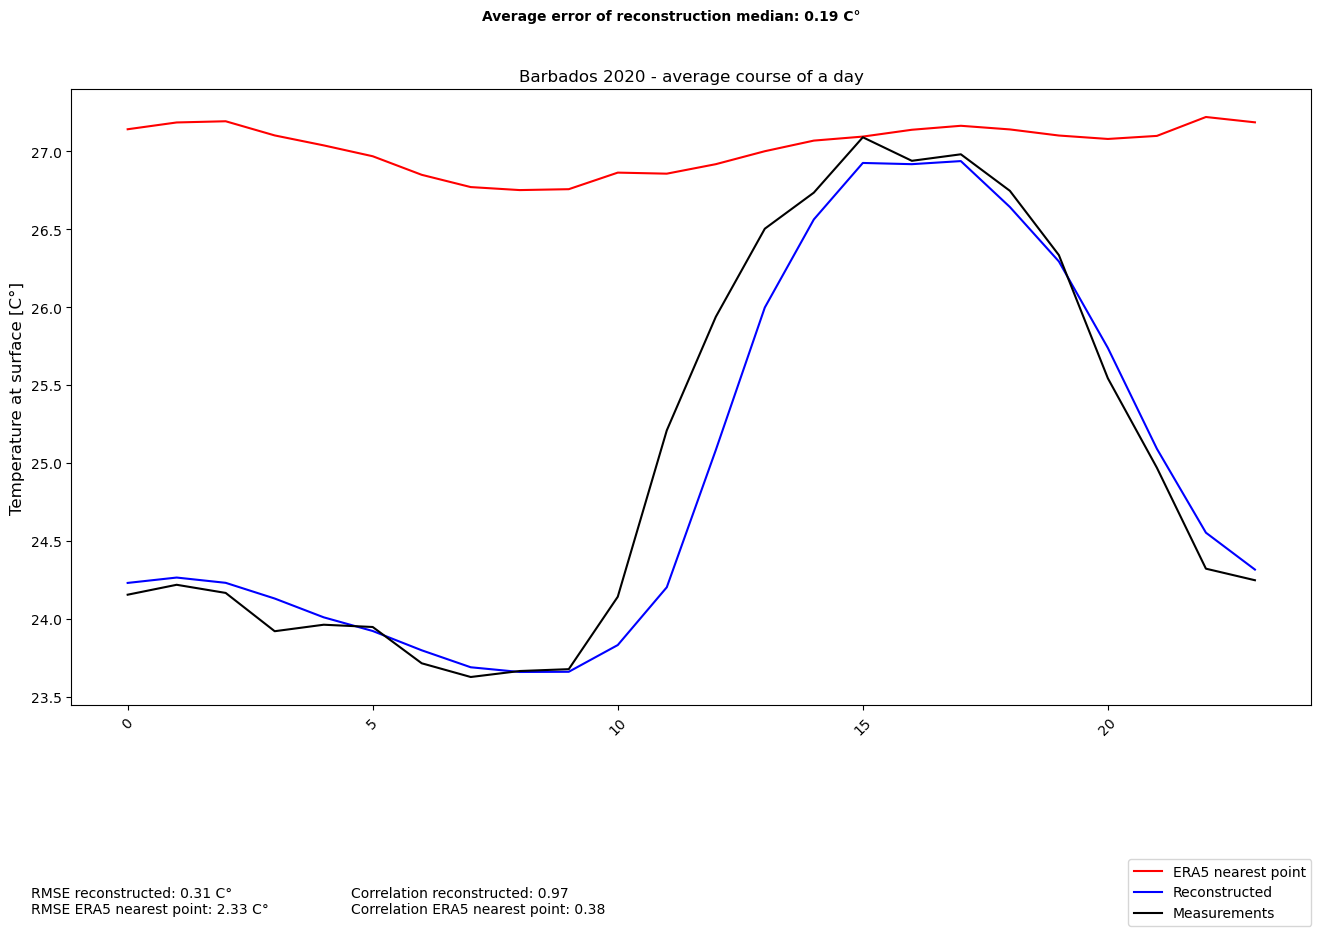

In [29]:
# calculate the mean of each 24 hours over the whole year

day_course_df = hourly_df.groupby(hourly_df.index.hour).mean()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - average course of a day"
plot_n_steps_of_df(day_course_df, as_delta = False, title=title)

# Average Course of the month

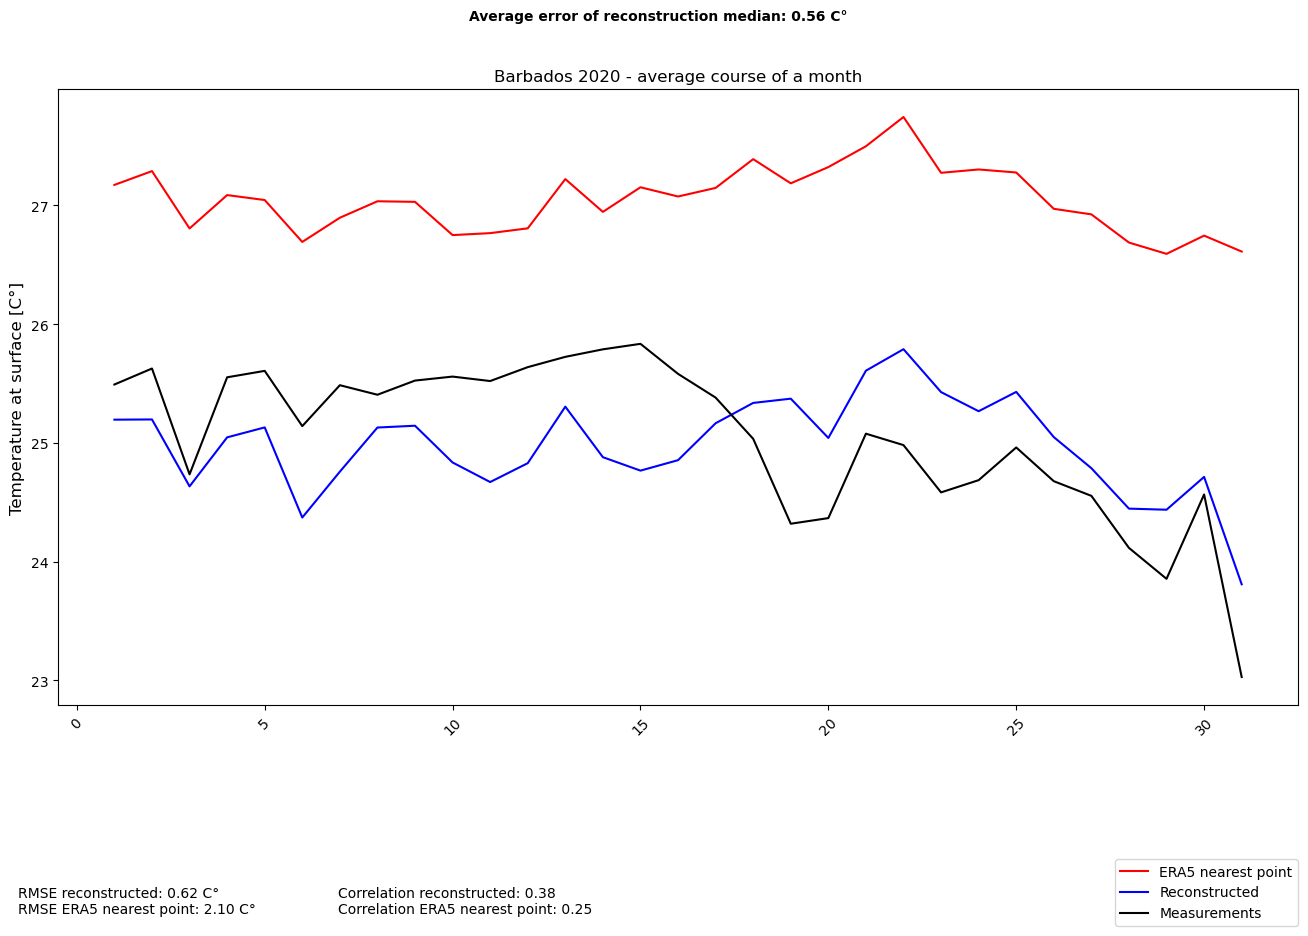

In [30]:
# calculate the mean of each day of a month over the whole year

month_course_df = hourly_df.groupby(hourly_df.index.day).mean()
title = f"{'Denver' if station_name == 'Marshall' else station_name} {test_year} - average course of a month"
plot_n_steps_of_df(month_course_df, as_delta = False, title=title)